# This tutorial notebook contains the workflow for high-throughput sequencing data processing and analysis using the QIIME2 platform. 
### This workkflow was used for teaching purpose during the summer course I offered on QIIME2 at the Centre for Marine Environmental Ecology, School of Environmental Science and Engineering, Tianjin University, China.

## Requirements
1. Seq Data provided by company (single-end or paired-end). 
2. Manifest file (.tsv)
3. Sample metadata file (.tsv)
4. reference database
5. Save 1-4 in working directory

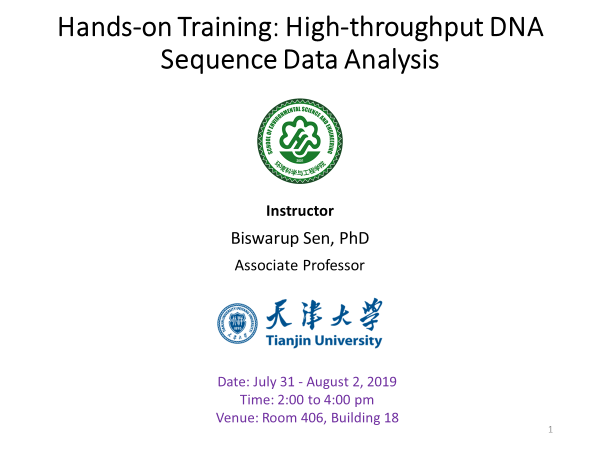!

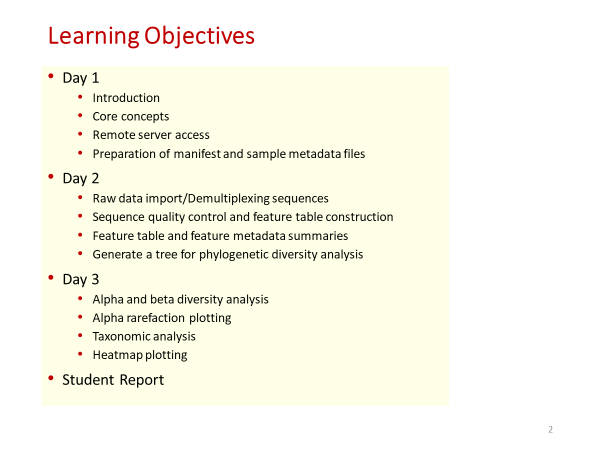!

In [5]:
pwd

'/'

In [1]:
cd /d/Bioinformatics/qiime2/KS-data-Ubuntu/KS-2019/ITS3-ITS4/final-eval-data40419/

/d/Bioinformatics/qiime2/KS-data-Ubuntu/KS-2019/ITS3-ITS4/final-eval-data40419


In [2]:
ls

PCoA-Unifrac.pdf*       metadata.txt*           table-dada2.qza
bar.pdf                 ordination.qza          table-taxonomy.biom
denoise-stat-dada2.qza  paired-end-demux.qza    table-taxonomy.tsv
dna-sequences.fasta     rarefied-otu-table.qza  tabulated-feature.qzv
funguild/               rarefied-table/         tabulated-feature.tsv*
level-2.csv*            rep-seqs-dada2.qza      taxonomy.tsv
level-3.csv*            rooted_tree.qza         taxonomy8-5.qza
level-6.csv*            scratch/


#Manifest file common for clean and raw data. Rechecking with raw data to see if cut-adapt has been performed. Rename the folder name as Data for running this command 

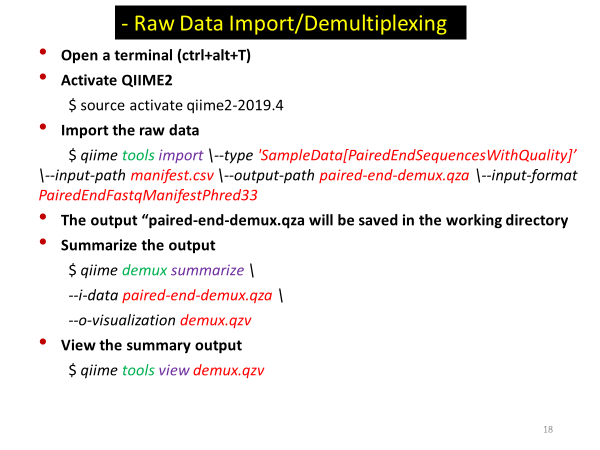!

In [ ]:
qiime tools import \
--type 'SampleData[PairedEndSequencesWithQuality]' \
--input-path manifest.csv \
--output-path paired-end-demux.qza \
--input-format PairedEndFastqManifestPhred33

In [29]:
qiime demux summarize \
--i-data paired-end-demux.qza \
--o-visualization demux.qzv

Usage: qiime demux summarize [OPTIONS]
Try "qiime demux summarize --help" for help.

Error: Invalid value for "--i-data": File "paired-end-demux.qza" does not exist.


In [ ]:
qiime tools view demux.qzv

#when paired end was used for its express and dada2 denoisepaired the sequences in the output were low. 
so tried again with single end forward reads only

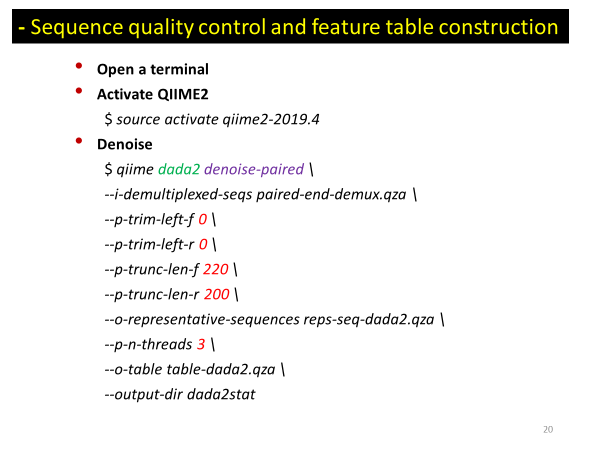!

In [37]:
qiime dada2 denoise-paired \
--i-demultiplexed-seqs paired-end-demux.qza \
--p-trim-left-f 0 \
--p-trim-left-r 0 \
--p-trunc-len-f 220 \
--p-trunc-len-r 200 \
--o-representative-sequences reps-dada2.qza \
--p-n-threads 3 \
--o-table table-dada2.qza \
--output-dir dada2stat

Imported Manifest-R1.csv as SingleEndFastqManifestPhred33 to single-end-demux.qza


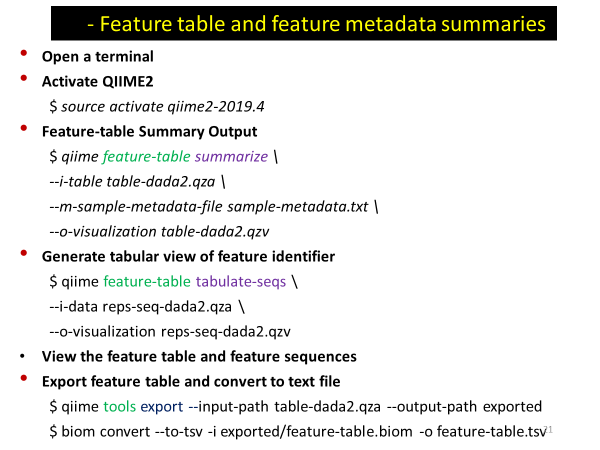!

In [38]:
! qiime feature-table summarize \
--i-table table-dada2.qza \
--m-sample-metadata-file sample-metadata.csv \
--o-visualization table-dada2.qzv

Saved Visualization to: single-demux.qzv


In [ ]:
qiime vsearch cluster-features-de-novo \
--i-sequences reps-seq-dada2.qza \
--i-table table-dada2.qza \
--p-perc-identity 0.97 \
--o-clustered-table otu-table.qza \
--o-clustered-sequences Otu-seqs.qza

In [ ]:
qiime tools export --input-path table-dada2.qza --output-path exported

In [ ]:
biom convert --to-tsv -i exported/feature-table.biom -o feature-table.tsv

In [ ]:
qiime tools import \
--type FeatureData[Sequence] \
--input-path sh_refs_qiime_ver8_99_s_02.02.2019.fasta \
--output-path sh_refs_qiime_ver8_99_s_02.02.2019.qza

In [ ]:
qiime tools import \
--type FeatureData[Taxonomy] \
--input-path sh_taxonomy_qiime_ver8_99_s_02.02.2019.txt \
--output-path sh_taxonomy_qiime_ver8_99_s_02.02.2019.qza \
--input-format HeaderlessTSVTaxonomyFormat

In [ ]:
qiime feature-classifier classify-consensus-blast \
--i-query reps-dada2.qza \
--i-reference-reads sh_refs_qiime_ver8_99_s_02.02.2019.qza \
--i-reference-taxonomy sh_taxonomy_qiime_ver8_99_s_02.02.2019.qza \
--p-perc-identity 0.945 \
--o-classification taxonomy.qza

In [ ]:
qiime taxa barplot \
--i-table table-dada2.qza \
--i-taxonomy taxonomy.qza \
--m-metadata-file sample-metadata.tsv \
--o-visualization taxa-bar-plot.qzv

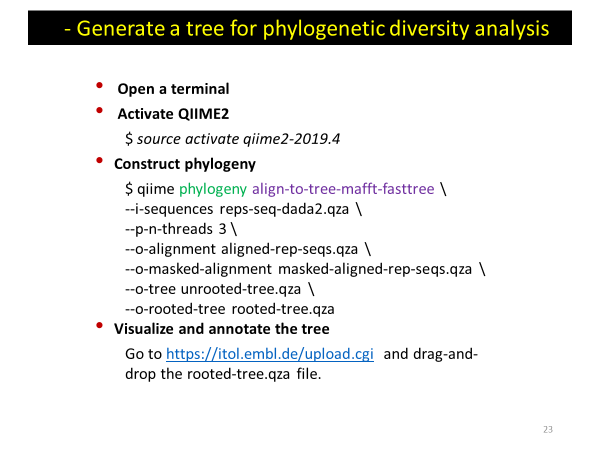!

In [ ]:
qiime phylogeny align-to-tree-mafft-fasttree \
--i-sequences reps-seqs-dada2.qza \
--p-n-threads 3 \
--o-alignment aligned-rep-seqs.qza \
--o-masked-alignment masked-aligned-rep-seqs.qza \
--o-tree unrooted-tree.qza \
--o-rooted-tree rooted-tree.qza

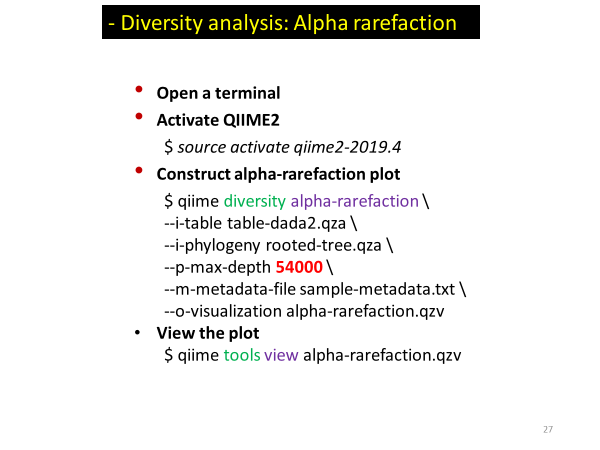!

In [ ]:
qiime diversity alpha-rarefaction \
--i-table table-dada2.qza \
--i-phylogeny rooted-tree.qza \
--p-max-depth 500 \
--m-metadata-file sample-metadata.txt \
--o-visualization alpha-rarefaction.qzv

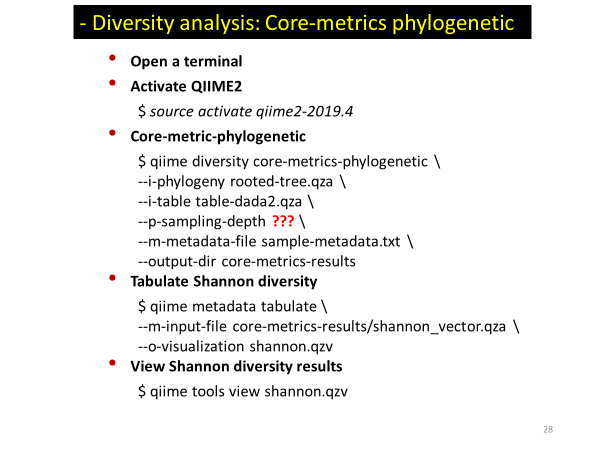!

In [ ]:
qiime diversity core-metrics-phylogenetic \
--i-phylogeny rooted-tree.qza \
--i-table table-dada2.qza \
--p-sampling-depth 500 \
--m-metadata-file sample-metadata.txt \
--output-dir core-metrics-results

In [ ]:
qiime metadata tabulate \
--m-input-file core-metrics-results/shannon_vector.qza \
--o-visualization shannon.qzv

In [ ]:
#filter feature-table filter-features
! qiime feature-table filter-features \
--i-table table-dada2.qza \
--p-min-frequency 1000 \
--o-filtered-table table-dada2-f.qza

In [ ]:
#filter feature-table filter-seqs
qiime feature-table filter-seqs \
--i-data rep-seqs-dada2.qza \
--i-table table-dada2-f.qza \
--o-filtered-data rep-seqs-dada2-f.qza

In [ ]:
qiime taxa collapse \
--i-table table-dada2.qza \
--i-taxonomy taxonomy.qza \
--p-level 3 \
--o-collapsed-table table-collapsed-dada2

In [ ]:
qiime feature-table heatmap \
--i-table table-collapsed-dada2.qza \
--m-metadata-file sample-metadata.txt \
--m-metadata-column Description \
--p-metric braycurtis \
--o-visualization heatmap.qzv

In [ ]:
! qiime feature-table heatmap \
--i-table table-dada2-top.qza \
--m-metadata-file sample-metadata.txt \
--m-metadata-column Description \
--p-metric braycurtis \
--o-visualization heatmap.qzv

In [36]:
! qiime dada2 denoise-paired \
--i-demultiplexed-seqs paired-end-demux-clean.qza \
--p-trim-left-f 0 \
--p-trim-left-r 0 \
--p-trunc-len-f 270 \
--p-trunc-len-r 274 \
--o-representative-sequences nonitsxdada2/reps-dada2.qza \
--p-n-threads 3 \
--o-table nonitsxdada2/table-dada2.qza \
--output-dir nonitsxdada2/dada2stat

Saved FeatureTable[Frequency] to: nonitsxdada2/table-dada2.qza
Saved FeatureData[Sequence] to: nonitsxdada2/reps-dada2.qza
Saved SampleData[DADA2Stats] to: nonitsxdada2/dada2stat/denoising_stats.qza


In [38]:
! qiime feature-table summarize \
--i-table nonitsxdada2/table-dada2.qza \
--m-sample-metadata-file sample-metadata.tsv \
--o-visualization nonitsxdada2/table-nonitsx-dada2.qzv

Saved Visualization to: nonitsxdada2/table-nonitsx-dada2.qzv


#to check effect of dada2 with forward single reads only without itsx trimming

In [42]:
! qiime dada2 denoise-single \
--i-demultiplexed-seqs single-end-demux.qza \
--p-trim-left 0 \
--p-trunc-len 270 \
--o-representative-sequences nonitsxdada2/Single/reps-single-dada2.qza \
--p-n-threads 3 \
--o-table nonitsxdada2/Single/table-single-dada2.qza\
--output-dir nonitsxdada2/Single/dada2statsingle

Saved FeatureTable[Frequency] to: nonitsxdada2/Single/table-single-dada2.qza
Saved FeatureData[Sequence] to: nonitsxdada2/Single/single-dada2.qza
Saved SampleData[DADA2Stats] to: nonitsxdada2/Single/dada2statsingle/denoising_stats.qza


In [44]:
! qiime feature-table summarize \
--i-table nonitsxdada2/Single/table-single-dada2.qza \
--m-sample-metadata-file sample-metadata.tsv \
--o-visualization nonitsxdada2/Single/table-single-dada2.qzv

Saved Visualization to: nonitsxdada2/Single/table-single-dada2.qzv


#the raw data had longer length than clean data so primers adapters and barcodes have been removed by company. 
#coninue further with clean data file

In [16]:
! qiime itsxpress trim-pair-output-unmerged \
--i-per-sample-sequences paired-end-demux-clean.qza \
--p-region ITS1 \
--p-taxa F \
--o-trimmed trimmed.qza

Saved SampleData[PairedEndSequencesWithQuality] to: trimmed.qza


#itsxpress trim using SequencesWithQuality forward reads only

In [43]:
! qiime itsxpress trim-single \
--i-per-sample-sequences single-end-demux.qza \
--p-region ITS1 \
--p-taxa F \
--p-threads 3 \
--o-trimmed single-trimmed.qza

Saved SampleData[SequencesWithQuality] to: single-trimmed.qza


In [23]:
! qiime dada2 denoise-paired \
--i-demultiplexed-seqs trimmed.qza \
--p-trim-left-f 0 \
--p-trim-left-r 0 \
--p-trunc-len-f 0 \
--p-trunc-len-r 0 \
--o-representative-sequences trimmed-dada2.qza \
--p-n-threads 3 \
--o-table table-trimmed-dada2.qza \
--output-dir dada2stat

Saved FeatureTable[Frequency] to: table-trimmed-dada2.qza
Saved FeatureData[Sequence] to: trimmed-dada2.qza
Saved SampleData[DADA2Stats] to: dada2stat/denoising_stats.qza


#dada2 denoise with Single end reads trimmed with itsxpress

In [45]:
! qiime dada2 denoise-single \
--i-demultiplexed-seqs single-trimmed.qza \
--p-trim-left 0 \
--p-trunc-len 0 \
--o-representative-sequences single-trimmed-dada2.qza \
--p-n-threads 3 \
--o-table table-single-trimmed-dada2.qza \single-trimmed-dada2
--output-dir dada2statsingle

Saved FeatureTable[Frequency] to: table-single-trimmed-dada2.qza
Saved FeatureData[Sequence] to: single-trimmed-dada2.qza
Saved SampleData[DADA2Stats] to: dada2statsingle/denoising_stats.qza


#tabulate and summarize OTU table after denoising using dada2 for pairedend reads next single end reads

In [28]:
! qiime feature-table summarize \
--i-table table-trimmed-dada2.qza \
--m-sample-metadata-file sample-metadata.tsv \
--o-visualization table-trimmed-dada2.qzv

Saved Visualization to: table-trimmed-dada2.qzv


In [46]:
! qiime feature-table summarize \
--i-table table-single-trimmed-dada2.qza \
--m-sample-metadata-file sample-metadata.tsv \
--o-visualization table-single-trimmed-dada2.qzv

Saved Visualization to: table-single-trimmed-dada2.qzv


#taxonomic assignment with itsxpress trimmed UNITE database. 

#Import sequence file from UNITE database and taxonomy file from UNITE database and convert to qza files

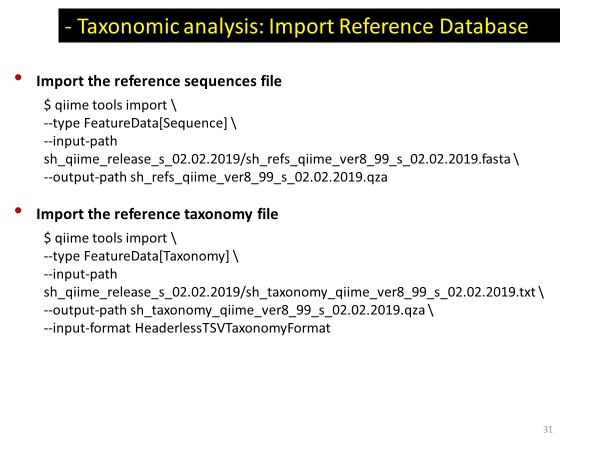!

In [ ]:
! qiime tools import \
--type FeatureData[Sequence] \
--input-path sh_refs_qiime_ver7_99_01.12.2017.fasta \
--output-path sh_refs_qiime_ver7_99_01.12.2017.qza

In [ ]:
! qiime tools import \
--type FeatureData[Taxonomy] \
--input-path sh_taxonomy_qiime_ver7_99_01.12.2017.txt \
--output-path sh_taxonomy_qiime_ver7_99_01.12.2017.qza \
--input-format HeaderlessTSVTaxonomyFormat

#train the classifier with the seq and taxonomy files imported above

In [ ]:
! qiime feature-classifier fit-classifier-naive-bayes \
--i-reference-reads sh_refs_qiime_ver7_99_01.12.2017.qza \
--i-reference-taxonomy sh_taxonomy_qiime_ver7_99_01.12.2017.qza \
--o-classifier sh_classifier_qiime_ver7_99_01.12.2017.qza

In [56]:
! qiime feature-classifier classify-consensus-blast \
--i-query single-trimmed-dada2.qza \
--i-reference-reads Taxonomy/sh_refs_qiime_ver7_99_01.12.2017.qza \
--i-reference-taxonomy Taxonomy/sh_taxonomy_qiime_ver7_99_01.12.2017.qza \
--p-perc-identity 0.945 \
--o-classification Single-R1/taxonomy-single-12-17-trim.qza

Saved FeatureData[Taxonomy] to: Single-R1/taxonomy-single-12-17-trim.qza


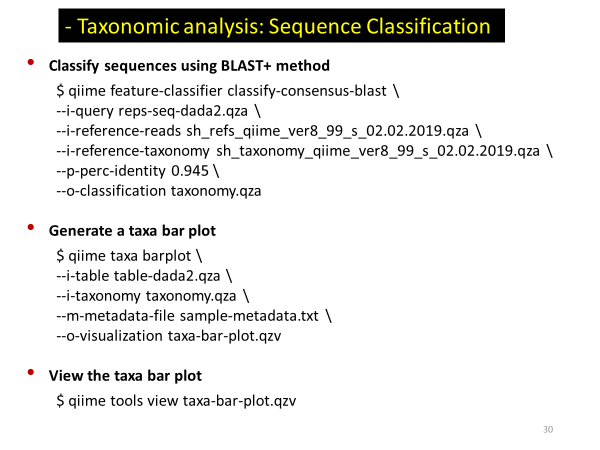!

In [58]:
! qiime feature-classifier classify-consensus-blast \
--i-query single-trimmed-dada2.qza \
--i-reference-reads Taxonomy/sh_refs_qiime_ver7_99_01.12.2017.qza \
--i-reference-taxonomy Taxonomy/sh_taxonomy_qiime_ver7_99_01.12.2017.qza \
--p-perc-identity 0.80 \
--o-classification Single-R1/taxonomy-class-single-12-17-trim.qza

Saved FeatureData[Taxonomy] to: Single-R1/taxonomy-class-single-12-17-trim.qza


#as per East China Sea paper 2018. assign seq to K_fungi 

In [62]:
! qiime feature-classifier classify-consensus-blast \
--i-query single-trimmed-dada2.qza \
--i-reference-reads Taxonomy/sh_refs_qiime_ver7_99_01.12.2017.qza \
--i-reference-taxonomy Taxonomy/sh_taxonomy_qiime_ver7_99_01.12.2017.qza \
--p-perc-identity 0.70 \
--o-classification Single-R1/taxonomy-kf-single-12-17-trim.qza

Saved FeatureData[Taxonomy] to: Single-R1/taxonomy-kf-single-12-17-trim.qza


#use developer version of taxonomy and sequence files for forward reads with dada2 without itsxpress trim
use next command to scrub lowercase characters from the sequences to avoid errors downstream

In [52]:
! awk '/^>/ {print($0)}; /^[^>]/ {print(toupper($0))}' developer/sh_refs_qiime_ver7_99_01.12.2017_dev.fasta > developer/sh_refs_qiime_ver7_99_01.12.2017_dev_uppercase.fasta

In [53]:
! qiime tools import \
 --type FeatureData[Sequence] \
 --input-path developer/sh_refs_qiime_ver7_99_01.12.2017_dev_uppercase.fasta \
 --output-path unite-ver7-99-seqs-01.12.2017.qza

Imported developer/sh_refs_qiime_ver7_99_01.12.2017_dev_uppercase.fasta as DNASequencesDirectoryFormat to unite-ver7-99-seqs-01.12.2017.qza


In [54]:
! qiime tools import \
 --type FeatureData[Taxonomy] \
 --input-path developer/sh_taxonomy_qiime_ver7_99_01.12.2017_dev.txt \
 --output-path unite-ver7-99-tax-01.12.2017.qza \
 --input-format HeaderlessTSVTaxonomyFormat

Imported developer/sh_taxonomy_qiime_ver7_99_01.12.2017_dev.txt as HeaderlessTSVTaxonomyFormat to unite-ver7-99-tax-01.12.2017.qza


In [ ]:
! qiime feature-classifier fit-classifier-naive-bayes \
 --i-reference-reads unite-ver7-99-seqs-01.12.2017.qza \
 --i-reference-taxonomy unite-ver7-99-tax-01.12.2017.qza \
 --o-classifier unite-ver7-99-classifier-01.12.2017.qza

In [57]:
! qiime feature-classifier classify-sklearn \
  --i-classifier Taxonomy/unite-ver7-99-classifier-01.12.2017.qza \
  --i-reads nonitsxdada2/Single/reps-single-dada2.qza \
  --o-classification nonitsxdada2/Single/taxonomy-single-sklearn.qza

Saved FeatureData[Taxonomy] to: nonitsxdada2/Single/taxonomy-single-dada2.qza


In [ ]:
! qiime feature-classifier classify-consensus-blast \
--i-query single-dada2.qza \
--i-reference-reads Taxonomy/sh_refs_qiime_ver7_99_01.12.2017.qza \
--i-reference-taxonomy Taxonomy/sh_taxonomy_qiime_ver7_99_01.12.2017.qza \
--p-perc-identity 0.945 \
--o-classification Single-R1/taxonomy-single-12-17-trim.qza

In [57]:
! qiime taxa barplot \
--i-table table-single-trimmed-dada2.qza \
--i-taxonomy Single-R1/taxonomy-single-12-17-trim.qza \
--m-metadata-file sample-metadata.tsv \
--o-visualization Single-R1/taxa-bar-plots.qzv

Saved Visualization to: Single-R1/taxa-bar-plots.qzv


In [59]:
! qiime taxa barplot \
--i-table table-single-trimmed-dada2.qza \
--i-taxonomy Single-R1/taxonomy-class-single-12-17-trim.qza \
--m-metadata-file sample-metadata.tsv \
--o-visualization Single-R1/taxa-bar-plots-class.qzv

Saved Visualization to: Single-R1/taxa-bar-plots-class.qzv


In [2]:
! qiime taxa barplot \
--i-table table-single-trimmed-dada2.qza \
--i-taxonomy Single-R1/taxonomy-kf-single-12-17-trim.qza \
--m-metadata-file sample-metadata.tsv \
--o-visualization Single-R1/taxa-bar-plots-kf.qzv

Saved Visualization to: Single-R1/taxa-bar-plots-kf.qzv


In [40]:
! qiime itsxpress trim-single --help

Usage: qiime itsxpress trim-single [OPTIONS]

  ITSxpress trimSingle is used for qza types with SquencesWithQuality or
  JoinedSequencesWithQuality. This means the qza must be in the
  SingleLanePerSampleSingleEndFastqDirFmt, and only contain one fastq file.

  The taxa list and variable for it:

  A = Alveolata

  B = Bryophyta

  C = Bacillariophyta

  D = Amoebozoa

  E = Euglenozoa

  F = Fungi

  G = Chlorophyta (green algae)

  H = Rhodophyta (red algae)

  I = Phaeophyceae (brown algae)

  L = Marchantiophyta (liverworts)

  M = Metazoa

  O = Oomycota

  P = Haptophyceae (prymnesiophytes)

  Q = Raphidophyceae

  R = Rhizaria

  S = Synurophyceae

  T = Tracheophyta (higher plants)

  U = Eustigmatophyceae

  ALL = All

Options:
  --i-per-sample-sequences ARTIFACT PATH SampleData[SequencesWithQuality]
                                  The artifact that contains the sequence
                                  file(s). Either Joined Paired or just a
                               

In [58]:
! qiime taxa barplot \
--i-table nonitsxdada2/Single/table-single-dada2.qza \
--i-taxonomy nonitsxdada2/Single/taxonomy-single-dada2.qza \
--m-metadata-file sample-metadata.tsv \
--o-visualization taxa-bar-plot-sklearn.qzv

Saved Visualization to: taxa-bar-plots.qzv


In [60]:
! qiime feature-classifier classify-consensus-blast \
--i-query nonitsxdada2/Single/reps-single-dada2.qza \
--i-reference-reads Taxonomy/unite-ver7-99-seqs-01.12.2017.qza \
--i-reference-taxonomy Taxonomy/unite-ver7-99-tax-01.12.2017.qza\
--p-perc-identity 0.945 \
--o-classification nonitsxdada2/Single/taxonomy-single-blast.qza

Saved FeatureData[Taxonomy] to: nonitsxdada2/Single/taxonomy-single-blast.qza


In [61]:
! qiime taxa barplot \
--i-table nonitsxdada2/Single/table-single-dada2.qza \
--i-taxonomy nonitsxdada2/Single/taxonomy-single-blast.qza \
--m-metadata-file sample-metadata.tsv \
--o-visualization nonitsxdada2/Single/taxa-bar-plot-blast.qzv

Saved Visualization to: nonitsxdada2/Single/taxa-bar-plot-blast.qzv


In [2]:
! qiime phylogeny align-to-tree-mafft-fasttree \
--i-sequences nonitsxdada2/Single/reps-single-dada2.qza \
--p-n-threads 3 \
--o-alignment nonitsxdada2/Single/aligned-rep-seqs.qza \
--o-masked-alignment nonitsxdada2/Single/masked-aligned-rep-seqs.qza \
--o-tree nonitsxdada2/Single/unrooted-tree.qza \
--o-rooted-tree nonitsxdada2/Single/rooted-tree.qza


Saved FeatureData[AlignedSequence] to: nonitsxdada2/Single/aligned-rep-seqs.qza
Saved FeatureData[AlignedSequence] to: nonitsxdada2/Single/masked-aligned-rep-seqs.qza
Saved Phylogeny[Unrooted] to: nonitsxdada2/Single/unrooted-tree.qza
Saved Phylogeny[Rooted] to: nonitsxdada2/Single/rooted-tree.qza


In [36]:
! qiime tools export --input-path nonitsxdada2/Single/table-single-dada2.qza --output-path nonitsxdada2/Single/exported

Exported nonitsxdada2/Single/table-single-dada2.qza as BIOMV210DirFmt to directory nonitsxdada2/Single/exported


In [37]:
! qiime tools export --input-path nonitsxdada2/Single/taxonomy-single-blast.qza --output-path nonitsxdada2/Single/exported

Exported nonitsxdada2/Single/taxonomy-single-blast.qza as TSVTaxonomyDirectoryFormat to directory nonitsxdada2/Single/exported


In [70]:
! cp nonitsxdada2/Single/exported/taxonomy.tsv nonitsxdada2/Single/exported/biom-taxonomy.tsv

#open the taxonomy.tsv file and manually change the headings

In [101]:
! biom add-metadata -i nonitsxdada2/Single/exported/feature-table.biom -o nonitsxdada2/Single/exported/table-with-taxonomy.biom --observation-metadata-fp nonitsxdada2/Single/exported/biom-taxonomy.tsv --observation-header OTUID,taxonomy,confidence --sc-separated taxonomy

/bin/sh: 1: biom-format: not found


In [104]:
! biom convert -i nonitsxdada2/Single/exported/table-with-taxonomy.biom -o nonitsxdada2/Single/exported/table-with-taxonomy.tsv --to-tsv

In [102]:
! biom head -i nonitsxdada2/Single/exported/table-with-taxonomy.biom

# Constructed from biom file
#OTU ID	A11	A12	A61	A62	A63
626174f1a6e8829520900864d1618825	0.0	0.0	0.0	0.0	0.0
73a84c73614b3b98a96f04560be22025	0.0	0.0	10223.0	0.0	0.0
7ba184e0296a713b63ca3daa24400317	83.0	214.0	18.0	3814.0	7.0
8d75ba75e5a4084a6335dde778f5f72e	0.0	0.0	0.0	0.0	0.0
e25bf6f5477d41493bdb8e1451d8fcc3	0.0	136.0	0.0	0.0	0.0


In [26]:
! qiime diversity core-metrics-phylogenetic \
--i-phylogeny nonitsxdada2/Single/rooted-tree.qza \
--i-table nonitsxdada2/Single/table-single-dada2.qza \
--p-sampling-depth 15700 \
--m-metadata-file sample-metadata.tsv \
--output-dir nonitsxdada2/Single/final/core-metrics-results

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.
Saved FeatureTable[Frequency] to: nonitsxdada2/Single/final/core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties(['phylogenetic']) to: nonitsxdada2/Single/final/core-metrics-results/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: nonitsxdada2/Single/final/core-metrics-results/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: nonitsxdada2/Single/final/core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: nonitsxdada2/Single/final/core-metrics-results/evenness_vector.qza
Saved DistanceMatrix % Properties(['phylogenetic']) to: nonitsxdada2/Single/final/core-metrics-results/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties(['phylogenetic']) to: nonitsxdada2/Single/final/core-metrics-results/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: non